# Instruments related features

This notebook starts from the file generated at step 00 (notebook '00_analysis_instMapping.ipynb') and adds features that will be useful for the predictions.

## Data import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import os

In [2]:
#Instruments dataset
#import data
user = os.environ["USERNAME"]
filename = "190108_instrumentsdf"
datafolder = "C:/Users/{}/Dropbox/University/MscDataScience_Birkbeck/thesis_project/data/".format(user)
ReportDate = datetime.datetime(2018, 9, 28) #reference date on which data are received - all due dates after report date are related to open instruments

inst = pd.read_pickle(datafolder+filename)
inst.head()

,customer_id,customer_name_1,debtor_id,debtor_name_1,invoice_number,invoice_date,due_date,invoice_amount,purchase_amount,purchase_amount_open,...,value_date,currency,purchase_examination,prosecution,deduction_amount,payment_amount,payment_date,document_status,uid,ttype
uid,,,,,,,,,,,,,,,,,,,,,
!17M529/1K:0350001/41405,2004035,Yawara GmbH,0350001,KONE AG,!17M529/1K,2017-10-27,2017-11-26,7263.27,7263.27,0.0,...,2017-10-27,Schweizer Franken,NaN,Nein,NaN,"[nan, nan, nan, nan, nan]","[NaT, NaT, NaT, NaT, NaT]",storniert,!17M529/1K:0350001/41405,"[0, 3, 2, 2, 7]"
.4078:62811/42717,2004022,Fortuna Personalberatung GmbH,62811,Christian Rüedi AG,.4078,2017-11-07,2017-12-07,824.20,824.20,0.0,...,2017-11-07,Schweizer Franken,NaN,Nein,0.0,"[824.2, 824.2]","[2017-12-11 00:00:00, 2017-12-11 00:00:00]",historisch,.4078:62811/42717,"[0, 1]"
0000138939:002/3266,002-1001,Softub Inc.,002,Softub Schweiz AG,0000138939,2016-03-18,2016-06-16,55566.00,55566.00,0.0,...,2016-03-18,US-Dollar,NaN,Nein,0.0,"[55566.0, 55566.0]","[2016-09-14 00:00:00, 2016-09-14 00:00:00]",historisch,0000138939:002/3266,"[0, 1]"
0000140268:002/5158,002-1001,Softub Inc.,002,Softub Schweiz AG,0000140268,2016-05-26,2016-09-23,54595.80,54595.80,0.0,...,2016-05-26,US-Dollar,NaN,Nein,0.0,"[54595.8, 54595.8]","[2016-11-10 00:00:00, 2016-11-10 00:00:00]",historisch,0000140268:002/5158,"[0, 1]"
0000140699:002/7114,002-1001,Softub Inc.,002,Softub Schweiz AG,0000140699,2016-06-22,2016-10-20,60150.00,60150.00,0.0,...,2016-06-22,US-Dollar,NaN,Nein,0.0,"[50644.5, 557.89, 8947.61, 50644.5, 557.89, 89...","[2017-02-17 00:00:00, 2017-03-28 00:00:00, 201...",historisch,0000140699:002/7114,"[0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]"


### 1. Add some new fields to instruments

In [3]:
#add some fields to instruments
inst["nrecords"] = inst.posting_date.apply(lambda x: len(x))
#non-ordered transaction types without multiples
inst["ttypeset"] = inst.ttype.apply(lambda x: tuple(set(x)))
 

### 2. Instruments count, bad instruments removal, count of past due instruments

In [4]:
#count different types of instruments
print("Instruments total: ", inst.shape[0])
ii = [True]*inst.shape[0] #index of good instruments
badi = inst.ttypeset.apply(lambda x: (4 in x) or (16 in x)) #@@note the hardcoded transaction type codes - bulk confirmation and nans need to be removed
print("bulk_purchase or nan in transaction type: {:}".format(sum(badi)))
ii = ii & ~badi
print("Removing {:} instruments with invoice_amount<0...".format(sum(inst.invoice_amount<=0.009)))
inst = inst[ii & (inst.invoice_amount>0.009)].copy()

print("remaining ", inst.shape[0])
print("Non zero discharge_amount: ", inst[inst.discharge_amount>0].shape[0])
print("Non zero deducted_amount: ", inst[inst.deduction_amount>0].shape[0])
print("Non zero deducted or discharge_amount: ", 
      inst[(inst.discharge_amount>0) | (inst.deduction_amount>0)].shape[0])

dayst1 = 90
#deeming the following to be the only repayment transaction types:
#"incoming payments", "Subsequent assignement of the payment", "Cancel invoice client", 
#"Cancellation invoice", "Credit entry"
print("Past due more than {:} days and no repayments: {:}".format(dayst1, inst[
      inst.due_date.apply(lambda x: (ReportDate - x).days > dayst1) & \
      inst.ttypeset.apply(lambda x: set(x).isdisjoint({1,5,6,7,9}))].shape[0] ))

dayst2 = 180
print("Past due more than {:} days and no repayments: {:}".format(dayst2, inst[
      inst.due_date.apply(lambda x: (ReportDate - x).days > dayst2) & \
      inst.ttypeset.apply(lambda x: set(x).isdisjoint({1,5,6,7,9}))].shape[0] ))



Instruments total:  66593
bulk_purchase or nan in transaction type: 6770
Removing 3 instruments with invoice_amount<0...
remaining  59820
Non zero discharge_amount:  2696
Non zero deducted_amount:  1232
Non zero deducted or discharge_amount:  3916
Past due more than 90 days and no repayments: 3977
Past due more than 180 days and no repayments: 3396


### 3. impairments and past due

Definitions used:
impairment1: any non-zero discharge or deducted amount  
impairment2: discharge or dedected > 0.02invoice_amount  
pastdueXX: instrument is dies more than XX days prior to report date and no transactions of type 4,5, or 10 recorded  

  
Note1: it is not clear if should not consider some other transaction types as repayments  
Note2: instruments with partial repayments will not be flagged. The current probelm is that we do not understand aggregation of paid amounts between repayements

In [5]:
#replace nan with 0
def _xor0(x):
    return 0. if np.isnan(x) else x
xor0 = np.vectorize(_xor0)

In [6]:
impthr = 0.009 #threshold for impairments
imp2thr = 0.04 #threshold for impairment_3

#define the discharge loss as difference between invoice_amount and discharge amount...
inst["discharge_loss"] = xor0(inst.invoice_amount - inst.discharge_amount)
inst.loc[pd.isnull(inst.discharge_amount), "discharge_loss"] = 0. #...but it is 0 for NaN discharge_amount

#define the presence of impairment1 as deduction_amount>0.009
inst["has_impairment1"] =  inst.deduction_amount>impthr

#define the presence of impairment2 as discharge_loss>0.009
inst["has_impairment2"] =  inst.discharge_loss>impthr

#define the presence of impairment3 as discharge_loss>proportion of invoice amount or deduction_amount>proportion of invoice amount
inst["has_impairment3"] =  (inst.discharge_loss>imp2thr*inst.invoice_amount) | (inst.deduction_amount>imp2thr*inst.invoice_amount)

#instrument which are open and more than 90 days past the due date 
inst["is_pastdue90"] =  inst.due_date.apply(lambda x: (ReportDate - x).days > 90) & (inst.document_status=="offen")

#instrument which are open and more than 180 days past the due date
inst["is_pastdue180"] =  inst.due_date.apply(lambda x: (ReportDate - x).days > 180) & (inst.document_status=="offen")

#instrument with prosecution
inst["has_prosecution"] = inst.prosecution.apply(lambda x: x=="Ja")

#amount of the last payment for a certain instrument
inst["last_payment_amount"] = xor0(inst.payment_amount.apply(lambda x: x[-1]))

#sum of all the distinct entries for a single instrument
inst["total_repayment"] = xor0(inst.payment_amount.apply(lambda x: sum(list(set(x))))) #sum of distinct entries

#sum of discharge_loss and deduction_amount
inst["total_impairment"] = xor0(inst.discharge_loss) + xor0(inst.deduction_amount)

#field indicating if an instrument is open or not
inst["is_open"] = inst.document_status.apply(lambda x: x=="offen")

#sort instruments dataset by invoice date and debtor id
inst = inst.sort_values(by=["invoice_date", "debtor_id"], ascending=[True, True])

#WEEKEND COUNTS (weekend payments highlight is apparently useful for fraud detection)
#nan if all dates are none; fraction of weekday()==5 or 6 amond non-nan dates otherwise
def we_share(lst):
    """
    This function return the ratio of weekend payments for an instrument. nan if there's no weekend payment.
    """
    res = np.nan
    wec = 0
    datec = 0
    for x in lst:
        if not pd.isnull(x):
            #print(x.weekday())
            datec+=1
            if x.weekday()>4:
                wec+=1
    if datec>0:
        res=wec/datec
    return res

inst["we_payment_share"] = inst.payment_date.apply(lambda x: we_share(x))
print("Weekend payment shares: {:}".format(inst.we_payment_share.value_counts()))

#this indicates if an instrument has a purchase amount (if not, the client is not involved in repayment)
inst["has_purchase"] = inst.purchase_amount.apply(lambda x: x>0.009)

#this indicates if an instrument has a deduction amount
inst["has_deduction"] = inst.deduction_amount.apply(lambda x: x>0.009)

#this field indicates if an instrument is due
inst["is_due"] = inst.due_date.apply(lambda x: x < ReportDate)

Weekend payment shares: 0.000000    47431
1.000000      165
0.500000        5
0.200000        1
0.111111        1
Name: we_payment_share, dtype: int64


# Rules for aggregating paid_amounts

In [ ]:
# add columns for paid amounts on certain transaction types:

inst2=inst.copy()

inst2["pa_purchase_invoice"] = inst2.payment_amount * [1 if x else 0 for x in list(inst2.transaction_type=="Purchase invoice")]
inst2["pa_add_purchase_invoice"] = inst2.payment_amount * [1 if x else 0 for x in list(inst2.transaction_type=="Additional purchase invoice")]
inst2["pa_incoming"] = inst2.payment_amount * [1 if x else 0 for x in list(inst2.transaction_type=="incoming payments")]
inst2["pa_subs_assignement"] = inst2.payment_amount * [1 if x else 0 for x in list(inst2.transaction_type=="Subsequent assignment of the payment")]
inst2["pa_cancel_invoice_client"] = inst2.payment_amount * [1 if x else 0 for x in list(inst2.transaction_type=='Cancel invoice client')]

i_g = inst2.groupby("uid")
ag = i_g.agg({"uid": "first", "invoice_amount": "first", "pa_purchase_invoice": "sum",
              "pa_add_purchase_invoice": "sum",
             "pa_incoming": "sum",
             "deduction_amount": "first",
             "purchase_amount": "first",
              "document_status": "first"})

In [ ]:
#sum of paid amount on "Purchase invoice" never exceeds invoice_amount
#ag[["uid", "pa_purchase_invoice", "invoice_amount"]][ag.pa_purchase_invoice >= ag.invoice_amount+0.001]

In [ ]:
#additional purchase invoice amount paid_amount should not be added to purchase invoice amount
print("non zero additional purchase invoice amounts: ",
      ag[ag.pa_add_purchase_invoice>0].shape[0])
print("aggregate payment amount on purchases and additional purchases exceeds invoice amount: ",
      ag[["pa_purchase_invoice", "invoice_amount"]][
    ag.pa_purchase_invoice + ag.pa_add_purchase_invoice >= ag.invoice_amount+0.001].shape[0])
print("instances where purchase amount is above sum of payment amounts: ",
     ag[["pa_purchase_invoice", "invoice_amount", "purchase_amount", "pa_add_purchase_invoice"]][
    (ag.pa_purchase_invoice + ag.pa_add_purchase_invoice < ag.invoice_amount+0.01) 
         & (ag.pa_add_purchase_invoice>0)].shape[0])
print("Full list:")
print(     ag[[ "pa_purchase_invoice", "invoice_amount", "purchase_amount", "pa_add_purchase_invoice"]][
    (ag.pa_purchase_invoice + ag.pa_add_purchase_invoice < ag.invoice_amount+0.01) 
         & (ag.pa_add_purchase_invoice>0)])

In [15]:
#many cases where purchase amount is much higher than the sum of payment amounts
print("purchase invoice and additional purchase invoice adds up to less than purchase amount: ",
    ag[["uid", "pa_purchase_invoice", "invoice_amount"]][
    ag.pa_purchase_invoice + ag.pa_add_purchase_invoice < ag.purchase_amount-0.001].shape[0])

NameError: name 'ag' is not defined

In [16]:
#the only cases where pa_purchase_invoice+ pa+add_purhcase_invoice do not exceed purchase amount
#are among instances where purchase amountpayment amount  
ag[["uid", "pa_purchase_invoice", "invoice_amount", "purchase_amount", "pa_add_purchase_invoice"]][
    (ag.pa_purchase_invoice + ag.pa_add_purchase_invoice - 
          ag.invoice_amount < 0.01) & (ag.pa_add_purchase_invoice>0)]


NameError: name 'ag' is not defined

# Rules for aggregating repayments

In [18]:
i_g = tr.groupby("uid")
ag = i_g.agg({"invoice_amount": "first", 
              "pa_purchase_invoice": "sum",
              "pa_add_purchase_invoice": "sum",
              "pa_incoming": "sum",
              "deduction_amount": "first",
              "purchase_amount": "first",
              "pa_subs_assignement": "sum",
              "pa_cancel_invoice_client": "sum",
              "document_status": "first"})


In [19]:
#additional purchase invoice amount paid_amount should not be added to purchase invoice amount
print("Aggregating payments out from _payment amount_")
print(len(ag.index), " instruments")
balance = ag.pa_purchase_invoice - \
                (ag.pa_incoming+ag.pa_subs_assignement+ag.pa_cancel_invoice_client)

print("payments out == payments in: ", ag[np.abs(balance)<0.011].shape[0])
print("payments out > payments in: ", ag[balance>=0.011].shape[0])
print("payments out < payments in: ", ag[balance<=-0.011].shape[0])

Aggregating payments out from _payment amount_
66609  instruments
payments out == payments in:  65004
payments out > payments in:  0
payments out < payments in:  1605


Aggregating payments out from _purchase amount_
66609  instruments
payments out == payments in:  49210
payments out > payments in:  8855
payments out < payments in:  8544


(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00,
        3.0000e+00, 6.0000e+00, 1.4000e+01, 4.9000e+01, 4.8283e+04]),
 array([-198.51121076, -194.52098655, -190.53076233, -186.54053812,
        -182.5503139 , -178.56008969, -174.56986547, -170.57964126,
        -166.58941704, -162.59919283, -158.60896861, -154.61874439,
        -150.62852018, -146.63829596, -142.64807175, -138.65784753,
        -134.66762332, -130.6773991 , -126.687

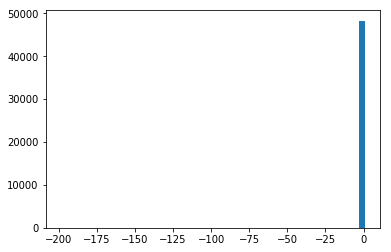

In [100]:
print("Aggregating payments out from _purchase amount_")
print(len(ag.index), " instruments")
balance = ag.purchase_amount - \
                (ag.pa_incoming+ag.pa_subs_assignement+ag.pa_cancel_invoice_client)

print("payments out == payments in: ", ag[np.abs(balance)<0.011].shape[0])
print("payments out > payments in: ", ag[balance>=0.011].shape[0])
print("payments out < payments in: ", ag[balance<=-0.011].shape[0])

plt.hist(balance[ag.purchase_amount>0.01]/ag.purchase_amount[ag.purchase_amount>0.01], bins=50)

In [61]:
inst.head().transpose()

uid,2744:79/231,2861:79/232,2932:79/233,1472:489/688,2042:512/645
customer_id,2004008,2004008,2004008,2004009,2004009
customer_name_1,jobs united GmbH,jobs united GmbH,jobs united GmbH,PM Personal GmbH,PM Personal GmbH
debtor_id,79,79,79,489,512
debtor_name_1,Quadroni Linard,Quadroni Linard,Quadroni Linard,Style Interiors,Elektropartner AG
invoice_number,2744,2861,2932,1472,2042
invoice_date,2013-07-23 00:00:00,2013-07-30 00:00:00,2013-08-06 00:00:00,2013-08-13 00:00:00,2013-08-13 00:00:00
due_date,2013-08-02 00:00:00,2013-08-09 00:00:00,2013-08-16 00:00:00,2013-08-23 00:00:00,2013-08-23 00:00:00
invoice_amount,913.7,2233.45,1370.5,9195.1,4594.6
purchase_amount,0,0,0,0,0
purchase_amount_open,0,0,0,0,0


In [1]:
inst.has_impairment1[:100].sum()

NameError: name 'inst' is not defined

In [45]:

#set up buyer and seller dataframes
b_g = inst.groupby("debtor_name_1")
#build an aggregation dictionary

#aggregate by keeping a list
agg_bdict = dict(zip(["customer_id", "customer_name_1", "debtor_id", "uid",
                      "has_impairment1", "has_impairment2", "is_pastdue90", "is_pastdue180",
                      "has_prosecution", "is_open"
                     ],  ["nunique"]*4 + ["sum"]*6  ))

                                                           
#aggregate by first value...
buyer = b_g.agg(agg_bdict)
#buyer.head(20)

#set up buyer and seller dataframes
s_g = inst.groupby("customer_name_1")
#build an aggregation dictionary

#aggregate by keeping a list
agg_sdict = dict(zip(["customer_id", "debtor_name_1", "debtor_id", "uid",
                      "has_impairment1", "has_impairment2", "is_pastdue90", "is_pastdue180",
                      "has_prosecution", "is_open"
                     ],
                   ["nunique"]*4 + ["sum"]*6  ))

                                                           
#aggregate by first value...
seller = s_g.agg(agg_sdict)
seller.head(20)

,customer_id,debtor_name_1,debtor_id,uid,has_impairment1,has_impairment2,is_pastdue90,is_pastdue180,has_prosecution,is_open
customer_name_1,,,,,,,,,,
ABC Steel Products GBP,1,16,17,81,55.0,3.0,0.0,0.0,0.0,0.0
ABC Steel Products GmbH,1,65,66,183,31.0,0.0,0.0,0.0,0.0,0.0
Accente AG,1,2,2,47,29.0,19.0,3.0,2.0,0.0,10.0
Adanus AG,1,76,77,1605,5.0,4.0,39.0,30.0,46.0,140.0
Areion Trading GmbH,1,1,1,3,2.0,1.0,0.0,0.0,0.0,0.0
Arnosti Arkuba (Schweiz) AG,1,11,11,656,4.0,1.0,108.0,108.0,0.0,108.0
Axom GmbH,1,6,6,109,1.0,0.0,36.0,36.0,36.0,36.0
BG Business Group AG,1,3,3,3,0.0,0.0,3.0,3.0,0.0,3.0
BKV Bauhilfsdienste UG & Co.KG (EUR01),1,1,1,13,4.0,4.0,3.0,0.0,0.0,5.0


In [47]:
saveprefix = "09272018_"
seller.to_pickle(datafolder + saveprefix + "seller.pkl")
buyer.to_pickle(datafolder + saveprefix + "buyer.pkl")



In [10]:
i_g = inst2.groupby("uid")
ag = i_g.agg({"invoice_amount": "first", 
              "pa_purchase_invoice": "sum",
              "pa_add_purchase_invoice": "sum",
              "pa_incoming": "sum",
              "deduction_amount": "first",
              "purchase_amount": "first",
              "pa_subs_assignement": "sum",
              "pa_cancel_invoice_client": "sum",
              "document_status": "first"})


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'uid' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\groupby\groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


KeyError: 'pa_purchase_invoice'

In [19]:
#additional purchase invoice amount paid_amount should not be added to purchase invoice amount
print("Aggregating payments out from _payment amount_")
print(len(ag.index), " instruments")
balance = ag.pa_purchase_invoice - \
                (ag.pa_incoming+ag.pa_subs_assignement+ag.pa_cancel_invoice_client)

print("payments out == payments in: ", ag[np.abs(balance)<0.011].shape[0])
print("payments out > payments in: ", ag[balance>=0.011].shape[0])
print("payments out < payments in: ", ag[balance<=-0.011].shape[0])

Aggregating payments out from _payment amount_
66609  instruments
payments out == payments in:  65004
payments out > payments in:  0
payments out < payments in:  1605


Aggregating payments out from _purchase amount_
66609  instruments
payments out == payments in:  49210
payments out > payments in:  8855
payments out < payments in:  8544


(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00,
        3.0000e+00, 6.0000e+00, 1.4000e+01, 4.9000e+01, 4.8283e+04]),
 array([-198.51121076, -194.52098655, -190.53076233, -186.54053812,
        -182.5503139 , -178.56008969, -174.56986547, -170.57964126,
        -166.58941704, -162.59919283, -158.60896861, -154.61874439,
        -150.62852018, -146.63829596, -142.64807175, -138.65784753,
        -134.66762332, -130.6773991 , -126.687

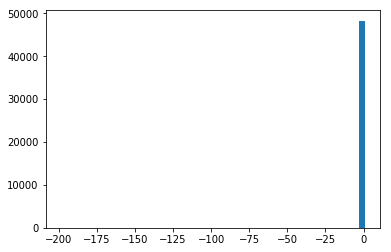

In [100]:
print("Aggregating payments out from _purchase amount_")
print(len(ag.index), " instruments")
balance = ag.purchase_amount - \
                (ag.pa_incoming+ag.pa_subs_assignement+ag.pa_cancel_invoice_client)

print("payments out == payments in: ", ag[np.abs(balance)<0.011].shape[0])
print("payments out > payments in: ", ag[balance>=0.011].shape[0])
print("payments out < payments in: ", ag[balance<=-0.011].shape[0])

plt.hist(balance[ag.purchase_amount>0.01]/ag.purchase_amount[ag.purchase_amount>0.01], bins=50)

In [60]:
#save instrument+features dataframe
prefix = "190108_"
filename = "instrumentsdf2"
inst.to_pickle(datafolder + prefix + filename)